In [8]:
import yfinance as yf
import os
from datetime import datetime
import numpy as np

In [9]:
"""
This function downloads historical stock price data for a specified stock label. 
It downloads the data within a given time range using the Yahoo Finance API.

This function will use the yf.download method from the Yahoo Finance library, 
and will return the adjusted closing price.
"""

folder_path = "/Users/aleksandra.rancic/Desktop/MLOps_Project/MLOps/dataset"

def download_dataset(label, start_date):
    
    end_date = datetime.now().strftime('%Y-%m-%d')
    
    stock_data = yf.download(label, start = start_date, end = end_date)
    
    file_name = f"{label}_stock_data.csv"
    
    file_path = os.path.join(folder_path, file_name)
    
    stock_data.to_csv(file_path)
    
    return stock_data

# label = the stock label symbol ('AAPL' for Apple Inc.)
# start_date = the starting date for the historical data 
# end_date = the ending date for the historical data
# The format for dates is 'YYYY-MM-DD'.


In [10]:
#Download stock data
label = 'AAPL'
start_date = '2014-09-12'
adj_close_data = download_dataset(label, start_date)

[*********************100%***********************]  1 of 1 completed


In [11]:
import pandas as pd

df = pd.read_csv('/Users/aleksandra.rancic/Desktop/MLOps_Project/MLOps/dataset/AAPL_stock_data.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-12,25.302500,25.547501,25.270000,25.415001,22.566168,250504400
1,2014-09-15,25.702499,25.762501,25.360001,25.407499,22.559505,245266000
2,2014-09-16,24.950001,25.315001,24.722500,25.215000,22.388575,267632400
3,2014-09-17,25.317499,25.450001,25.147499,25.395000,22.548403,243706000
4,2014-09-18,25.482500,25.587500,25.389999,25.447500,22.595018,149197600


In [12]:
def preprocess_data(data, sequence_length):
    """
    Preprocesses the raw stock price data and creates input sequences for LSTM model.

    Parameters:
    -----------
    data: array-like
        The stock price data (or any time series data) to preprocess.

    sequence_length: int
        The number of previous time steps to consider in each input sequence.

    Returns:
    --------
    sequences: list of tuples
        Each tuple contains:
        - sequence: the input sequence for the LSTM model.
        - target: the next value after the sequence, used for prediction.
    """
    sequences = []
    for i in range(len(data) - sequence_length):
        # Direct slicing for both NumPy arrays and DataFrames
        sequence = data[i:i+sequence_length]
        target = data[i+sequence_length]
        sequences.append((sequence, target))

    return sequences


In [29]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def split_and_scale_data(data, test_size = 0.2, sequence_length = 60):
    """
    This function splits a time series dataset into training and testing sets, scales the data, 
    and creates input sequences for LSTM model training and testing.

    Parameters:
    -----------
    data: array-like
        The stock price (or any time series data) that you want to split and preprocess.
        Typically, this will be a Pandas DataFrame or NumPy array with one or more columns.

    test_size: float, optional
        The proportion of the data to reserve for testing. Default is 0.2 (20% test, 80% train).

    sequence_length: int, optional
        The number of previous time steps to consider in each input sequence. This defines how much
        historical data the model will use to predict the next value. Defalut is 60 (usually 60 days).

    Returns:
    --------
    X_train: numpy array
        The input sequences for the LSTM model from the training dataset. Each sequence contains 
        'sequence_length' time steps of stock prices.
    y_train: numpy array
        The corresponding target values for each sequence in the training dataset. These are the values
        the model will learn to predict.
    X_test: numpy array
        The input sequences for the LSTM model from the test dataset.
    y_test: numpy array
        The corresponding target values for the test dataset.
    scaler: MinMaxScaler object
        The scaler object used to scale the data, allowing you to inverse-transform the data later
        for interpretation after predictions.


    Notes:
    -------
    The function scales the entire dataset between 0 and 1 using MinMaxScaler before splitting
    into training and testing sets. LSTMs require normalized data for optimal performance. 
    """
    
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaled_data = scaler.fit_transform(data)

    train_size = int(len(scaled_data)*(1-test_size))
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    train_sequences = preprocess_data(train_data, sequence_length)
    test_sequences = preprocess_data(test_data, sequence_length)

    X_train = np.array([seq[0] for seq in train_sequences])
    y_train = np.array([seq[1] for seq in train_sequences])
    X_test = np.array([seq[0] for seq in test_sequences])
    y_test = np.array([seq[1] for seq in test_sequences])

    np.save("/Users/aleksandra.rancic/Desktop/MLOps_Project/MLOps/ML_Model_API/venv/X_train.npy", X_train)
    np.save("/Users/aleksandra.rancic/Desktop/MLOps_Project/MLOps/ML_Model_API/venv/y_train.npy", y_train)
    np.save("/Users/aleksandra.rancic/Desktop/MLOps_Project/MLOps/ML_Model_API/venv/X_test.npy", X_test)
    np.save("/Users/aleksandra.rancic/Desktop/MLOps_Project/MLOps/ML_Model_API/venv/y_test.npy", y_test)

    return X_train, y_train, X_test, y_test, scaler
    

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
from keras.callbacks import EarlyStopping

def train_lstm_model(X_train, y_train, sequence_length, n_features=1, epochs=50, batch_size=32):
    model = Sequential()
    model.add(Input(shape=(sequence_length, n_features)))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Use EarlyStopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])
    
    return model



In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def explore_data(df):
    print("Data Overview:")
    print(df.head())
    print("\nData Description:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())

explore_data(df)

Data Overview:
         Date       Open       High        Low      Close  Adj Close  \
0  2014-09-12  25.302500  25.547501  25.270000  25.415001  22.566168   
1  2014-09-15  25.702499  25.762501  25.360001  25.407499  22.559505   
2  2014-09-16  24.950001  25.315001  24.722500  25.215000  22.388575   
3  2014-09-17  25.317499  25.450001  25.147499  25.395000  22.548403   
4  2014-09-18  25.482500  25.587500  25.389999  25.447500  22.595018   

      Volume  
0  250504400  
1  245266000  
2  267632400  
3  243706000  
4  149197600  

Data Description:
              Open         High          Low        Close    Adj Close  \
count  2533.000000  2533.000000  2533.000000  2533.000000  2533.000000   
mean     90.866083    91.839761    89.947258    90.937001    88.879748   
std      62.242477    62.904125    61.615367    62.293016    62.781882   
min      22.500000    22.917500    22.367500    22.584999    20.720036   
25%      35.099998    35.305000    34.939999    35.160000    32.739231   

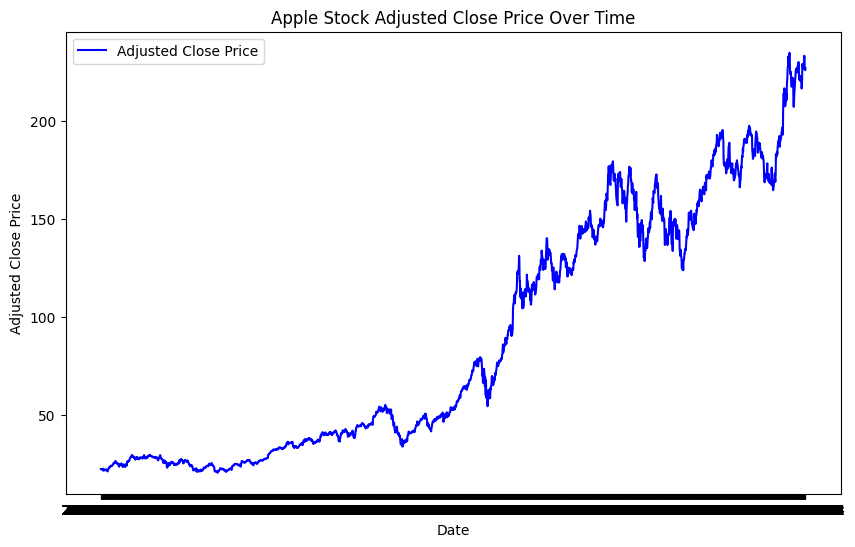

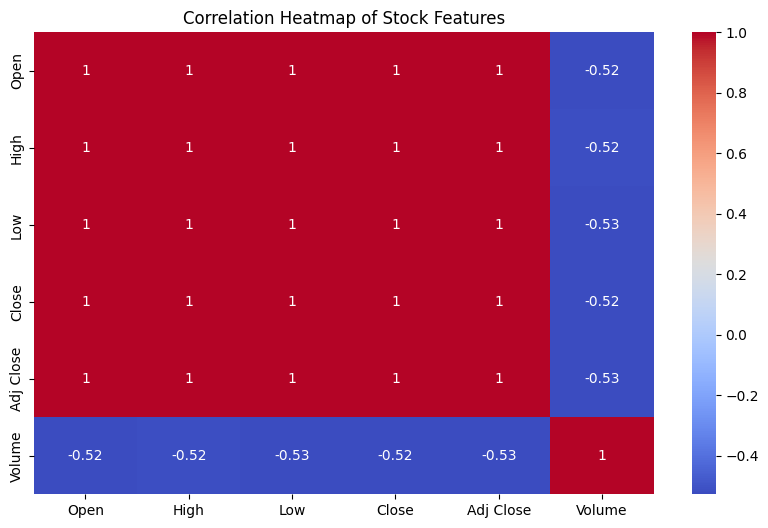

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_data(df):
    plt.figure(figsize = (10, 6))
    plt.plot(df['Date'], df['Adj Close'], label = "Adjusted Close Price", color = 'blue')
    plt.title('Apple Stock Adjusted Close Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.show();

    numeric_df = df.drop(columns = ['Date'])

    plt.figure(figsize = (10, 6))
    sns.heatmap(numeric_df.corr(), annot = True, cmap = 'coolwarm')
    plt.title('Correlation Heatmap of Stock Features')
    plt.show();

visualize_data(df)

In [16]:
sequence_length = 60
X_train, y_train, X_test, y_test, scaler = split_and_scale_data(df[['Adj Close']].values, test_size=0.2, sequence_length=sequence_length)


In [17]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (1966, 60, 1)
y_train shape: (1966, 1)


In [18]:
import numpy as np

print(type(X_train))  
print(type(y_train))  


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input

lstm_model = train_lstm_model(X_train, y_train, sequence_length, n_features=1, epochs=50, batch_size=32)


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0092 - val_loss: 0.0011
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.2757e-04 - val_loss: 0.0015
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.8941e-04 - val_loss: 7.6047e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.8248e-04 - val_loss: 7.4793e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.4247e-04 - val_loss: 0.0025
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.8320e-04 - val_loss: 0.0021
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.4936e-04 - val_loss: 0.0017
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.4561e-04 - val_loss: 0.0014
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.1178e-04 - val_loss: 0.0043
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.7714e-04 - val_loss: 5.6794e-04
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.5573e-04 - val_loss: 0.0011
Epoch 12/50

In [20]:
import numpy as np
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_test, y_test, scaler, filename='model_metrics.json'):
    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Reverse the scaling on predictions and true values
    predictions_rescaled = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Compute evaluation metrics
    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test_rescaled - predictions_rescaled) / y_test_rescaled)) * 100
    r2 = r2_score(y_test_rescaled, predictions_rescaled)

    # Print evaluation metrics
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
    print(f"R-squared (R²): {r2}")

    metrics = {
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "Mean Absolute Error (MAE)": mae,
        "Mean Absolute Percentage Error (MAPE)": mape,
        "R-squared (R²)": r2
    }

    # Save metrics to a JSON file
    with open(filename, 'w') as f:
        json.dump(metrics, f)

    print(f"Metrics saved to {filename}")
    
    return predictions_rescaled, mse, mae, rmse, mape, r2

predictions_rescaled, mse, mae, rmse, mape, r2 = evaluate_model(lstm_model, X_test, y_test, scaler, filename='lstm_model_metrics.json')


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Mean Squared Error (MSE): 19.289287719744305
Root Mean Squared Error (RMSE): 4.391957162785665
Mean Absolute Error (MAE): 3.4038965280690707
Mean Absolute Percentage Error (MAPE): 1.8332545431555665%
R-squared (R²): 0.9664305415683752
Metrics saved to lstm_model_metrics.json


In [21]:
# Function to make predictions on new data
def make_predictions(model, X_test):
    predictions = model.predict(X_test)
    predictions_rescaled = scaler.inverse_transform(predictions)
    return predictions_rescaled

# Example: Make predictions on test data
predictions = make_predictions(lstm_model, X_test)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


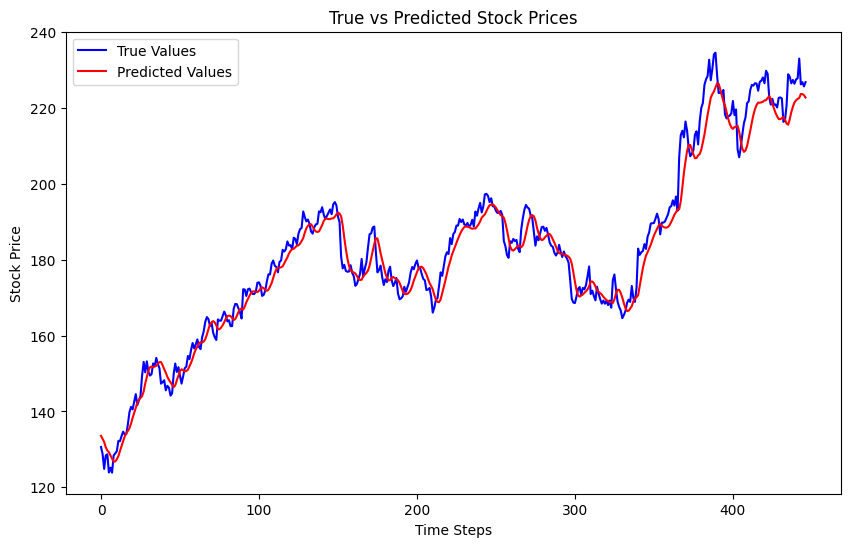

In [22]:
# Visualization of the predictions vs true values
def plot_predictions(predictions, y_test, scaler):
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_rescaled, color='blue', label='True Values')
    plt.plot(predictions, color='red', label='Predicted Values')
    plt.title('True vs Predicted Stock Prices')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# Call the function to plot predictions vs true values
plot_predictions(predictions_rescaled, y_test, scaler)


In [23]:
from keras.models import load_model
import joblib

# Save the model using Keras
lstm_model.save('lstm_model.h5')

# Load the model to ensure it can be used after saving
loaded_model = load_model('lstm_model.h5')

# Save the loaded Keras model as a pickle file
joblib.dump(loaded_model, 'lstm_model.pkl')

# Optionally, confirm the model is saved by loading it back
model_from_pkl = joblib.load('lstm_model.pkl')


/Users/aleksandra.rancic/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [24]:
# Save the scaler to a file
joblib.dump(scaler, 'minmax_scaler.pkl') 


['minmax_scaler.pkl']

In [25]:
for column in df.columns:
    print (column)
    

Date
Open
High
Low
Close
Adj Close
Volume


In [26]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-12,25.302500,25.547501,25.270000,25.415001,22.566168,250504400
1,2014-09-15,25.702499,25.762501,25.360001,25.407499,22.559505,245266000
2,2014-09-16,24.950001,25.315001,24.722500,25.215000,22.388575,267632400
3,2014-09-17,25.317499,25.450001,25.147499,25.395000,22.548403,243706000
4,2014-09-18,25.482500,25.587500,25.389999,25.447500,22.595018,149197600
5,2014-09-19,25.572500,25.587500,25.125000,25.240000,22.410778,283609600
6,2014-09-22,25.450001,25.535000,25.145000,25.264999,22.432983,211153600
7,2014-09-23,25.150000,25.735001,25.135000,25.660000,22.783699,253608800
8,2014-09-24,25.540001,25.712500,25.299999,25.437500,22.586140,240687200
9,2014-09-25,25.127501,25.177500,24.430000,24.467501,21.724871,400368000


In [27]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2533 entries, 0 to 2532
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2533 non-null   object 
 1   Open       2533 non-null   float64
 2   High       2533 non-null   float64
 3   Low        2533 non-null   float64
 4   Close      2533 non-null   float64
 5   Adj Close  2533 non-null   float64
 6   Volume     2533 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 138.7+ KB


In [28]:
from keras.models import load_model

# Load the Keras model
loaded_model = load_model('lstm_model.h5')

# Print the model summary
loaded_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,053 (277.55 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)